# Time Series Prediction with Knowledge Based Deep Learning ($KDL$)



AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-08 16:15:14

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Pretraining

_Lienard intermittancy_

The `lienard_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Lienard System

In [3]:
data = np.genfromtxt('datasets/lienard_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

1.00123132
1         0.000005
2         0.000010
3         0.000015
4         0.000020
5         0.000024
            ...   
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
139871    0.000000
Name: 1, Length: 139871, dtype: float64
2         0.000005
3         0.000005
4         0.000005
5         0.000005
6         0.000005
            ...   
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
139871    0.000000
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_दिल्ली WIND SPEED_

In [6]:
data = pd.read_csv("datasets/delhi.csv")
training_set = data.iloc[:, 3]
print(training_set)

0       0.000000
1       2.980000
2       4.633333
3       1.233333
4       3.700000
          ...   
1457    3.547826
1458    6.000000
1459    6.266667
1460    7.325000
1461    0.000000
Name: wind_speed, Length: 1462, dtype: float64


In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0         0.000005
1         0.000010
2         0.000015
3         0.000020
4         0.000024
            ...   
139866    0.000000
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
Name: 1, Length: 139871, dtype: float64
0         0.000005
1         0.000005
2         0.000005
3         0.000005
4         0.000005
            ...   
139865    0.000000
139866    0.000000
139867    0.000000
139868    0.000000
139869    0.000000
Name: 1, Length: 139870, dtype: float64


In [8]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Lienard Systems_)

<AxesSubplot:>

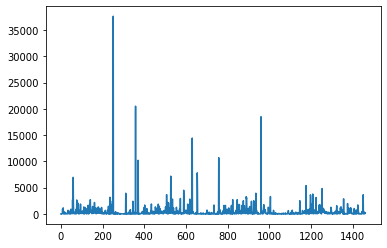

In [9]:
a = 0.45
b = 0.5
c = -0.5
L = df.iloc[:,2] + a*df.iloc[:,0]*df.iloc[:,1] +c*df.iloc[:,0] +b* df.iloc[:,0]**3
L.plot()

## Preprocessing the data into supervised learning

In [10]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)  # ,18,19
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10    0.000000   2.980000   4.633333   1.233333   3.700000   1.480000   
11    2.980000   4.633333   1.233333   3.700000   1.480000   6.300000   
12    4.633333   1.233333   3.700000   1.480000   6.300000   7.142857   
13    1.233333   3.700000   1.480000   6.300000   7.142857  12.500000   
14    3.700000   1.480000   6.300000   7.142857  12.500000   7.400000   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)    var1(t)   var2(t)   var3(t)  
10   6.300000   7.142857  12.500000   7.400000  10.571429  0.000048  0.000003  
11   7.142857  12.500000   7.400000  10.571429  13.228571  0.000051  0.000003  
12  12.500000   7.400000  10.571429  13.228571   4.633333  0.000054  0.000002  
13   7.400000  10.571429  13.228571   4.633333   0.616667  0.000056  0.000002  
14  10.571429  13.228571   4.633333   0.616667   0.528571  0.000058  0.000001  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       '

## Train and Test Split

In [11]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1160, 1, 10) (1160, 3) (291, 1, 10) (291, 3)


## Defining the Physical Loss

In [12]:
a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
def phys(y_pred, y_true):
    return mean_absolute_error(y_true[:,2] + a*y_true[:,0]*y_true[:,1] +c*y_true[:,0] +b* y_true[:,0]**3, y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] +a*y_pred[:-2]*(y_pred[1:-1]-y_pred[:-2]) +c*y_pred[:-2] +b* y_pred[:-2]**3
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] +a*y_real[:-2]*(y_real[1:-1]-y_real[:-2]) +c*y_real[:-2] +b* y_real[:-2]**3
    return(mean_absolute_error(pred,real))

## Model ($KDL$)

In [13]:
a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:,0] - y_pred[:,0])
    squared_difference2 = tf.square(y_true[:,2]-y_pred[:,2])
    squared_difference1 = tf.square(y_true[:,1]-y_pred[:,1])    
    squared_difference3 = tf.square(y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False)

Epoch 1/500
19/19 [==============================] - 3s 30ms/step - loss: 0.0235 - val_loss: 0.0128
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0091
Epoch 3/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0086
Epoch 4/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0084
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0083
Epoch 6/500
19/19 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0082
Epoch 7/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 8/500
19/19 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0080
Epoch 9/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0079
Epoch 10/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 11

## Metrics ($KDL$)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
phy = phys2(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

10/10 [==============================] - 0s 1ms/step
(291, 3)
(291, 10)
Test RMSE: 3.541
Test MAE: 2.665


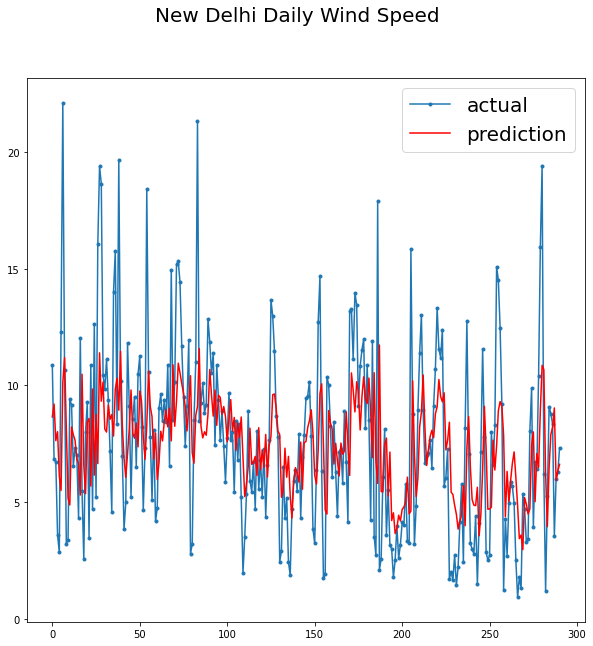

In [15]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('New Delhi Daily Wind Speed', fontsize=20)
plt.legend(fontsize=20)
plt.show()